In [14]:
"""
    정리
    1. agent를 통해서 policy(랜덤값이 앱실론보다 작으면 랜덤 인덱스와 랜덤 action을, 
                            그렇지 않으면 내부 신경망(LSTM)에 state값을 넣어 
                            가능한 모든 action에 대한 action_values(Q_values) 중 가장 큰 값에 해당하는 인덱스와 그 값을 반환한다.
                            이때 사용되는 내부 신경망은 main_network이다.)
        에 맞는 action_index와 action_value를 찾아낸다.
    2. 찾아낸 action_index와 action_value를 env에 넣어서 RF 모델을 돌린 뒤 next_state(다음 action 집합)와 reward(정확도)를 찾아낸다.
    3. memory(replay buffer)에 현재 state와 action_index, 그리고 위에서 도출된 next_state, reward를 넣는다.
    4. replay buffer에서 원하는 batch size만큼 sample(state, action_index, reward, next_state)을 뽑아낸다.
    5. sample의 state를 main_network에 넣어서 도출된 값들 중 action index에 맞는 값을 뽑고 이를 main Q 값으로 한다.
    6. sample의 next_state를 target_network에 넣어서 값을 도출한 뒤, 그 중 가장 큰 값을 찾아낸다.
    7. 위에서 찾아낸 값을 Q라고 한다면, reward + gamma(discount factor)*Q = target Q로 정한다.
    8. mainQ와 targetQ를 loss function에 넣어서 내부 신경망 파라미터를 역전파로 업데이트 한다. 이때 옵티마이저도 사용된다.
    9. 이 과정을 반복하여 main Q가 target Q에 가까워질 수 있게 한다.
"""

"""    
    더 나아가서,
    1. multi agent를 사용해야하나?
    
    state 설정
    만약 넣은 state가 100,None,2,1,0,0(defalut) 라면, action value는 
    3^6=729개의 조합에 대해 q-value를 뽑고 그 중 하나를 고르는 것.
    따라서 state는 (729, 6)의 크기를 갖는다.
    
    deep q 이유
    만약 일반 q learning을 쓸 때, 
    하나의 하이퍼파라미터 당 10개의 tracking을 한다고 가정하면, 10^6만큼의 q-table이 필요하게 된다.
    따라서 시/공간 효율성을 위해 하이퍼파라미터 조합에 대한 q-value 값을 표현해주는 신경망을 학습시키는 것이 도움이 될 수 있다.
    
    장점
    1. 기존 hyperparameter tunning 방식은 내가 가능한 조합을 미리 설계해주어야 했다. 그래서 경험적으로 가능한 조합에 대한 지식이 있어야한다.
       하지만 강화학습에서는 step을 통해 조합을 찾으므로 미리 가능한 조합을 설계해둘 필요가 없다.
    2. 학습된 모델을 데이터가 추가된 경우에도 그대로 사용할 수 있다.
    3. 한번 만들어두면 시간 효율적이다.
    4. 학습된 모델을 파인튜닝하여 사용할 수 있다.
    5. 기존 방식은 내가 조합을 미리 제한해두기 때문에 최적의 조합인지에 대한 확신을 가지기 어렵다.
"""



'    \n    더 나아가서,\n    1. multi agent를 사용해야하나?\n    \n    state 설정\n    만약 넣은 state가 100,None,2,1,0,0(defalut) 라면, action value는 \n    3^6=729개의 조합에 대해 q-value를 뽑고 그 중 하나를 고르는 것.\n    따라서 state는 (729, 6)의 크기를 갖는다.\n    \n    deep q 이유\n    만약 일반 q learning을 쓸 때, \n    하나의 하이퍼파라미터 당 10개의 tracking을 한다고 가정하면, 10^6만큼의 q-table이 필요하게 된다.\n    따라서 시/공간 효율성을 위해 하이퍼파라미터 조합에 대한 q-value 값을 표현해주는 신경망을 학습시키는 것이 도움이 될 수 있다.\n    \n    장점\n    1. 기존 hyperparameter tunning 방식은 내가 가능한 조합을 미리 설계해주어야 했다. 그래서 경험적으로 가능한 조합에 대한 지식이 있어야한다.\n       하지만 강화학습에서는 step을 통해 조합을 찾으므로 미리 가능한 조합을 설계해둘 필요가 없다.\n    2. 학습된 모델을 데이터가 추가된 경우에도 그대로 사용할 수 있다.\n    3. 한번 만들어두면 시간 효율적이다.\n    4. 학습된 모델을 파인튜닝하여 사용할 수 있다.\n    5. 기존 방식은 내가 조합을 미리 제한해두기 때문에 최적의 조합인지에 대한 확신을 가지기 어렵다.\n'

In [15]:
import gym
import random
import numpy as np
import pandas as pd
from collections import deque, namedtuple
import copy
from itertools import product
import torch
from torch import nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm

In [16]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer

class h2y2_RF_Model():
    def __init__(self, cur_hyperparameter):
        self.model = RandomForestClassifier(**cur_hyperparameter, random_state=42)
        self.data = load_breast_cancer()
        x_data = pd.DataFrame(self.data.data, columns=self.data.feature_names)
        y_data = self.data.target
        self.train_x, self.test_x, self.train_y, self.test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
        
        
    def evaluate(self):
        self.model.fit(self.train_x, self.train_y)
        predict = self.model.predict(self.test_x)
        return accuracy_score(self.test_y, predict)
    

In [18]:
class H2Y2_env:
    
    def __init__(self):
        # initial
        self.comb_config = [[-50,0,50], [-2,0,2], [-1,0,1], [-1,0,1], [-0.1,0,0.1], [-0.1,0,0.1]]
        self.hyperparameter_list = ['n_estimators', 'max_depth', 'min_samples_split', 'min_samples_leaf', 'min_weight_fraction_leaf', 'min_impurity_decrease']
        self.epsilon = 1e-3
    
    # 하이퍼파라미터의 범위를 제한해주는 함수 ver1
    def check_bound(self, comb):        
        comb_sum = comb[1] + comb[2]
        if comb[0] == 'n_estimators':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'max_depth':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'min_samples_leaf':
            if comb_sum > 0:
                return int(comb_sum)
        elif comb[0] == 'min_samples_split':
            if comb_sum > 1:
                return int(comb_sum)
        elif comb[0] == 'min_weight_fraction_leaf':
            if comb_sum >= 0 and comb_sum <= 0.5:
                return float(comb_sum)
        elif comb[0] == 'min_impurity_decrease':
            if comb_sum >= 0 and comb_sum <= 1:
                return float(comb_sum)
        return comb[1]
    
    # 하이퍼파라미터의 범위를 제한해주는 함수 ver2
    def check_bound_ver2(self, comb):
        sample_state = []
        for i in range(len(comb[2])):
            comb_sum = comb[1] + comb[2][i]
            if comb[0] == 'n_estimators':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'max_depth':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_samples_leaf':
                if comb_sum > 0:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_samples_split':
                if comb_sum > 1:
                    sample_state.append(int(comb_sum))
            elif comb[0] == 'min_weight_fraction_leaf':
                if comb_sum >= 0 and comb_sum <= 0.5:
                    sample_state.append(float(comb_sum))
            elif comb[0] == 'min_impurity_decrease':
                if comb_sum >= 0 and comb_sum <= 1:
                    sample_state.append(float(comb_sum))
            else:
                sample_state.append(comb[1])
        return sample_state
    
    # hyper-parameter vector를 받아서 다음으로 가능한 모든 조합을 반환해주는 함수
    def make_state(self, cur_comb):
        comb = list(product(*self.comb_config))
        state = [tuple(map(self.check_bound, zip(self.hyperparameter_list, cur_comb, tuple_comb))) for tuple_comb in comb]
        # print(state)
        return state
        
    # q_value로 도출된 action_index가 어떤 observation을 가리키는지 확인한다.
    def mapping_action(self, state, action_index):
        all_state = list(product(*state))
        # print(len(all_state))
        return all_state[action_index]
        
    # hyper-parameter vector를 받아서 파라미터마다 가능한 값을 2차원으로 반환해주는 함수 ex)[[90, 100, 110], [2, 4, 6], [20, 25, 30], ...]
    def make_state_ver2(self, cur_comb):
        state = []
        for name, cur, comb in zip(self.hyperparameter_list, cur_comb, self.comb_config):
            state.append(self.check_bound_ver2([name,cur,comb]))
        # print(state)
        return state
    
    # env의 초기 state 설정, state는 hyper-parameter의 가능한 모든 조합으로 정의한다.
    def reset(self):
        init_hp = [random.randint(1, 100), random.randint(1, 100), random.randint(2, 100), random.randint(1, 100), random.random()/2, random.random()]
        state = self.make_state(init_hp)
        return state
        
    # action을 넣어서 next_state와 reward를 반환하는 함수
    def step(self, state, action_index):
        done = 0
        cur_comb = state[action_index]
        cur_hyperparameter = dict(zip(self.hyperparameter_list, cur_comb))
        rf_model = h2y2_RF_Model(cur_hyperparameter)
        reward = rf_model.evaluate()
        next_state = self.make_state(cur_comb)
        if reward == 1-self.epsilon:
            done = 1
        return next_state, reward, done

    # action을 넣어서 next_state와 reward를 반환하는 함수 ver2
    def step_ver2(self, state, action_index):
        done = 0
        cur_comb = self.mapping_action(state, action_index) # state에 맞게 현재 조합 매핑
        cur_hyperparameter = dict(zip(self.hyperparameter_list, cur_comb))
        rf_model = h2y2_RF_Model(cur_hyperparameter)
        reward = rf_model.evaluate()
        next_state = self.make_state_ver2(cur_comb)
        if reward == 1-self.epsilon:
            done = 1
        return next_state, reward, done
        

In [19]:
class H2Y2_Agent:
    def __init__(self):
        self.gamma = 0.99 # discount factor
        self.t_step = 0
        self.learn_freq = 4
        self.target_update_freq = 2000
        self.batch_size = 32
        self.action_size = 6

        self.main_network = Network(input_size=(729,6), out_size=729).float().to(device)
        self.target_network = Network(input_size=(729,6), out_size=729).float().to(device)
        self.target_network.load_state_dict(self.main_network.state_dict())
        
        self.hidden_state, self.cell_state = self.main_network.init_hidden_states(bsize=1)
        self.memory = ReplayBuffer(action_size = self.action_size, buffer_size = 10000, batch_size = self.batch_size, seed=42)
        self.optimizer = optim.Adam(self.main_network.parameters(), lr = 0.01)

    
    def select_action(self, state, eps=0.):
        # "내부의 신경망에 state를 넣어 모든 q_value를 뽑고, argmax로 선택"
        
        state = torch.from_numpy(np.array(state)).float().unsqueeze(0).to(device)
        self.main_network.eval()
        with torch.no_grad(): # 연산속도 증가
            action_values, _ = self.main_network.forward(state, bsize=1, time_step=1, hidden_state=self.hidden_state, cell_state=self.cell_state)
            # print(type(action_values)) # tuple
        self.main_network.train()
    
        # q_value를 최대로 만드는 action의 인덱스를 선택한다.
        if random.random() > eps:
            max_index = torch.argmax(action_values)
            return max_index
        else:
            random_index = random.choice(np.arange(self.action_size))
            return random_index
            
    def step(self, state, action_index, reward, next_state, done):
        # 메모리에 현재의 state, action_index, reward, next_state, done을 추가한다.
        self.t_step += 1 
        # print(self.t_step) # t_step은 episode가 바뀌어도 유지된다.
        self.memory.add(state, action_index, reward, next_state, done)
        
        # target_update로 정해둔 step마다, target network의 파라미터를 업데이트 한다.
        if (self.t_step % self.target_update_freq) == 0:
            self.target_network.load_state_dict(self.main_network.state_dict())
            
        # learn_freq로 정해둔 step마다, batch_size만큼의 샘플을 가지고 main_network를 학습시킨다.
        if (self.t_step % self.learn_freq) == 0:
            # batch_size만큼의 sample이 memory에 있으면 학습을 실행한다.
            if len(self.memory) > self.batch_size:
                experiences = self.memory.sample()
                self.learn(experiences, self.gamma)
    
    # main_network의 파라미터를 학습하는 함수
    def learn(self, experiences, gamma):
        states, actions, reward, next_states, dones = experiences
        hidden_batch, cell_batch = self.main_network.init_hidden_states(bsize=self.batch_size)

        # target_network를 통해 next_state에 대한 q_value 값을 도출하고, 그 중 max인 값을 선택한다.
        Q_targets_next, _ = self.target_network.forward(next_states,bsize=self.batch_size, time_step=1, hidden_state=hidden_batch, cell_state=cell_batch)
        Q_targets_next_max, __ = Q_targets_next.detach().max(dim=1)
        Q_targets_next_max = Q_targets_next_max.view(-1,1)
        # print(Q_targets_next_max.shape) # torch.Size([23328, 1]) -> torch.Size([32, 1])이 나와야함. -> 완료
        
        # q_value_target을 계산한다.
        Q_targets = reward + (gamma * Q_targets_next_max)
        # print(Q_targets.shape) # (32,1)

        # main_network를 통해 현재 state와 action 대한 q_value를 도출한다.
        Q_expected, _ = self.main_network.forward(states, bsize=self.batch_size, time_step=1, hidden_state=hidden_batch, cell_state=cell_batch)
        # print(Q_expected.shape) # (32,729)
        Q_expected_action = Q_expected.gather(dim=1, index = actions)
        # print(Q_expected_action.shape) # (32,1)

        loss = F.mse_loss(Q_expected_action, Q_targets)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


In [20]:
class ReplayBuffer:

    def __init__(self, action_size, buffer_size, batch_size, seed):

        self.action_size = action_size #각각의 action의 차원
        self.memory = deque(maxlen=buffer_size)  #버퍼의 최대 크기
        self.batch_size = batch_size # 배치 사이즈
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed) # 랜덤 시드
    
    # states, actions, rewards, next_states, done을 replay memory에 저장하는 함수
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    # replay memory에서 이전 과정에서 저장된 states, actions, rewards, next_states, done을 랜덤 추출하는 함수
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.vstack([torch.as_tensor(e.state).cpu() for e in experiences if e is not None])).float().to(device)
        # print(states.shape) # (32*729,6)
        actions = torch.from_numpy(np.vstack([torch.as_tensor(e.action).cpu() for e in experiences if e is not None])).long().to(device)
        # print(actions.shape) # (32,1)
        rewards = torch.from_numpy(np.vstack([torch.as_tensor(e.reward).cpu() for e in experiences if e is not None])).float().to(device)
        # print(rewards.shape) # (32,1)
        next_states = torch.from_numpy(np.vstack([torch.as_tensor(e.next_state).cpu() for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([torch.as_tensor(e.done).cpu() for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        # print(dones.shape) # (32,1)
  
        return (states, actions, rewards, next_states, dones)

    def __len__(self):
        return len(self.memory)

In [21]:
# gru도 비교해보면 좋다.

class Network(nn.Module):
    
    def __init__(self,input_size,out_size):
        super(Network,self).__init__()
        self.input_size = input_size
        self.out_size = out_size
        
        self.conv_layer1 = nn.Conv1d(in_channels=1,out_channels=32,kernel_size=8,stride=4)
        self.conv_layer2 = nn.Conv1d(in_channels=32,out_channels=64,kernel_size=4,stride=2)
        self.conv_layer3 = nn.Conv1d(in_channels=64,out_channels=64,kernel_size=3,stride=1)
        self.conv_layer4 = nn.Conv1d(in_channels=64,out_channels=512,kernel_size=7,stride=1)
        self.lstm_layer = nn.LSTM(input_size=512,hidden_size=512,num_layers=1,batch_first=True)
        self.adv = nn.Linear(in_features=512,out_features=self.out_size)
        self.val = nn.Linear(in_features=512,out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self,x,bsize,time_step,hidden_state,cell_state):
        x = x.view(bsize*time_step,1,-1)
        
        conv_out = self.conv_layer1(x)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer2(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer3(conv_out)
        conv_out = self.relu(conv_out)
        conv_out = self.conv_layer4(conv_out)
        conv_out = self.relu(conv_out)
        # print(conv_out.shape) # [1,512,~]
        
        conv_out = conv_out.view(bsize, -1, 512)
        
        lstm_out = self.lstm_layer(conv_out,(hidden_state,cell_state))
        out = lstm_out[0][:,time_step-1,:]
        h_n = lstm_out[1][0]
        c_n = lstm_out[1][1]
        
        adv_out = self.adv(out)
        val_out = self.val(out)
        
        qout = val_out.expand(bsize,self.out_size) + (adv_out - adv_out.mean(dim=1).unsqueeze(dim=1).expand(bsize,self.out_size))
        
        return qout, (h_n,c_n)
    
    def init_hidden_states(self,bsize):
        h = torch.zeros(1,bsize,512).float().to(device)
        c = torch.zeros(1,bsize,512).float().to(device)
        
        return h,c

In [22]:
# simple network
q_network = nn.Sequential(
    nn.Linear(6, 128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1))

In [23]:
class H2Y2:
    def __init__(self):
        self.agent = H2Y2_Agent()
        self.env = H2Y2_env()
        self.eps = 1.0 # 처음 epsilon
        self.scores = []
        self.end_times = []
        
    def dqn(self, n_episodes=10, max_t=10, eps_end=0.01, eps_decay=0.99):
            
        for i_episode in tqdm(range(1, n_episodes+1)):
            print(f"{i_episode} episode")
            state = self.env.reset()
            score = 0
            for t in range(1,max_t+1):
                # print(f"{t} time")
                action_index = self.agent.select_action(state, self.eps)
                next_state, reward, done = self.env.step(state, action_index)
                self.agent.step(state, action_index, reward, next_state, done)
                state = next_state
                score += reward
                if done:
                    break
            self.scores.append(score) # 하나의 episode에 대한 score(reward)를 저장
            self.end_times.append(t) # 몇번의 step을 통해 done에 도달하는지 확인
            self.eps = max(eps_end, eps_decay*self.eps) # decrease epsilon

            if i_episode % 5 == 0:
                torch.save(self.agent.main_network.state_dict(),f'./model/{i_episode}_cpu_test.pt') 
        # model save
        torch.save(self.agent.main_network.state_dict(),'./model/cpu_test.pt')
        return np.mean(self.scores)

In [40]:
# 모델 학습

h2y2 = H2Y2()

h2y2.dqn()

  0%|          | 0/10 [00:00<?, ?it/s]

1 episode


 10%|█         | 1/10 [00:01<00:12,  1.37s/it]

2 episode


 20%|██        | 2/10 [00:03<00:12,  1.54s/it]

3 episode


 30%|███       | 3/10 [00:03<00:08,  1.22s/it]

4 episode


 40%|████      | 4/10 [00:09<00:18,  3.15s/it]

5 episode


 50%|█████     | 5/10 [00:15<00:20,  4.00s/it]

6 episode


 60%|██████    | 6/10 [00:25<00:24,  6.04s/it]

7 episode


 70%|███████   | 7/10 [00:31<00:18,  6.14s/it]

8 episode


 80%|████████  | 8/10 [00:39<00:13,  6.67s/it]

9 episode


 90%|█████████ | 9/10 [00:45<00:06,  6.30s/it]

10 episode


100%|██████████| 10/10 [00:53<00:00,  5.31s/it]


7.340935672514621

In [41]:
h2y2.scores

[8.736842105263158,
 9.210526315789476,
 6.3157894736842115,
 6.3157894736842115,
 7.140350877192983,
 6.3157894736842115,
 6.3157894736842115,
 6.3157894736842115,
 7.257309941520469,
 9.485380116959066]

In [42]:
# test

def main():
    env = H2Y2_env()
    agent = H2Y2_Agent()
    state = env.reset()
    print(len(state))
    next_state, reward, done = env.step(state, 48)
    print(reward)
    print(done)
    
    
if __name__=='__main__':
    main()
    
# 실험해보면 좋을 것
# 1. 다음달에 새로운 데이터가 추가되었을 때도 잘 동작하는가 ( 데이터가 점진적으로 추가되었을 때 사용이 가능한가 )
# 2. 그리드서치, 랜덤서치, 베이지안 서치랑 비교
# 3. 데이터 도메인이 완전히 변경되었을 때도 lstm 레이어만 파인튜닝 튜닝하는 것으로 성능이 좋을까?

729
0.9415204678362573
0


In [25]:
# 모델 파라미터를 불러와서 하이퍼파라미터 튜닝

h2y2_test = H2Y2()
weights = torch.load('model/CNN_LSTM_WEIGHTS_50epoch_10000max_t.pt', map_location='cpu')
h2y2_test.agent.main_network.load_state_dict(weights)
max_t = 100
scores = []
done_t = []

for episode in range(1):
    state = h2y2_test.env.reset()
    for t in range(1,max_t+1):
        action_index = h2y2_test.agent.select_action(state, 0.01)
        next_state, reward, done = h2y2_test.env.step(state, action_index)
        state = next_state
        scores.append(reward)
        done_t.append(done)
        if done:
            break
        

# 1000번 step에 2분 소요
# 500번 step에 1분 소요
# 100번 step에 15초 소요


0.9532163742690059


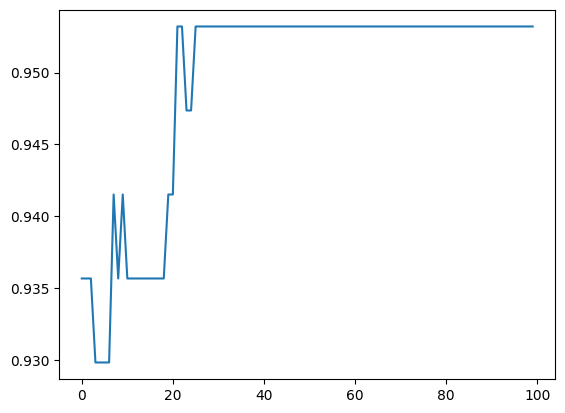

In [26]:
import matplotlib.pyplot as plt

plt.plot(scores)
print(max(scores))

In [21]:
print(done_t)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [27]:
# grid search
from sklearn.model_selection import GridSearchCV

grid_search = {'n_estimators': [10, 50, 100],
               'max_depth': [2, 4, 6],
               'min_samples_leaf': [1, 2, 3],
               'min_samples_split': [2, 3, 4],
               'min_weight_fraction_leaf': [0.1, 0.2, 0.3],
               'min_impurity_decrease': [0.1, 0.2, 0.3],
               }
data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
model = GridSearchCV(estimator = clf, param_grid = grid_search)
model.fit(train_x,train_y)
predict = model.best_estimator_.predict(test_x)
print("\nGrid Search : ", accuracy_score(test_y, predict))

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 돌렸을 때 (5^6 = 15625),
# 시간은 정말 많이...(1번당 5초가 걸린다고 했을 때, 15625*5초 = 21시간) 소요된다.

# 하이퍼파라미터 6개를 각각 3개씩 지정하여 돌렸을 때, (3^6 = 729)
# 시간은 5분이 걸린다.
# 정확도는 Grid Search :  0.9473684210526315

# 단점: 모든 조합을 다 해볼 순 있지만 시간이 매~우 많이 걸리고,
#       다 해봤다고 하더라도 내가 지정해준 조합 내에서만 움직이는 것이므로 최적을 보장할 순 없음.


Grid Search :  0.9473684210526315


In [23]:
# random search (주어진 범위 내에서 임의의 조합을 선택하여 최적의 조합을 탐색)
from sklearn.model_selection import RandomizedSearchCV

random_search = {'n_estimators': [10, 50, 100, 150, 200],
               'max_depth': [2, 4, 6, 8, 10],
               'min_samples_leaf': [1, 2, 3, 4, 5],
               'min_samples_split': [2, 3, 4, 5, 6],
               'min_weight_fraction_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
               'min_impurity_decrease': [0.1, 0.2, 0.3, 0.4, 0.5],
               }

data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

clf = RandomForestClassifier(random_state=42)
model = RandomizedSearchCV(estimator = clf, param_distributions = random_search, n_iter = 100, random_state= 42)
model.fit(train_x,train_y)
predict = model.best_estimator_.predict(test_x)
print("\nRandom Search : ", accuracy_score(test_y, predict))

# 하이퍼파라미터 6개를 각각 5개씩 지정하여 iteration을 100번 돌렸을 때,
# 시간은 1분 20초가 소요된다.
# 정확도는 Random Search :  0.9415204678362573

# 단점: 모든 조합을 다 안해봤을 수 있음.


Random Search :  0.9415204678362573


In [13]:
# Bayesian optimization

# 목적 함수
from sklearn.metrics import r2_score, mean_squared_error

def bayes_rf(n_estimators, max_depth, min_samples_leaf, min_samples_split, min_weight_fraction_leaf, min_impurity_decrease):
    model = RandomForestClassifier(
        n_estimators=int(n_estimators),
        max_depth = int(max_depth),
        min_samples_leaf = int(min_samples_leaf),
        min_samples_split = int(min_samples_split),
        min_weight_fraction_leaf = min_weight_fraction_leaf,
        min_impurity_decrease = min_impurity_decrease,
        random_state=42)
    
    data = load_breast_cancer()
    x_data = pd.DataFrame(data.data, columns=data.feature_names)
    y_data = data.target
    train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)
    
    model.fit(train_x,train_y)
    y_pred= model.predict(test_x)
    
    score=accuracy_score(y_pred, test_y)
    
    return score
    

# 베이지안 최적화
from bayes_opt import BayesianOptimization

Bayesian_search = {'n_estimators': [10, 50],
               'max_depth': [2, 4],
               'min_samples_leaf': [1, 2],
               'min_samples_split': [2, 3],
               'min_weight_fraction_leaf': [0.1, 0.2],
               'min_impurity_decrease': [0.1, 0.2]
               }
               
bo = BayesianOptimization(f=bayes_rf, pbounds=Bayesian_search, verbose=1, random_state=42)
bo.maximize(init_points=5, n_iter=100)

print(bo.max)
max_parameter = bo.max['params']
max_parameter['n_estimators']=int(max_parameter['n_estimators'])
max_parameter['max_depth']=int(max_parameter['max_depth'])
max_parameter['min_samples_leaf']=int(max_parameter['min_samples_leaf'])
max_parameter['min_samples_split']=int(max_parameter['min_samples_split'])


bo_tuned_rf = RandomForestClassifier(**max_parameter)
data = load_breast_cancer()
x_data = pd.DataFrame(data.data, columns=data.feature_names)
y_data = data.target
train_x, test_x, train_y, test_y = train_test_split(x_data, y_data, test_size=0.3, random_state=42)

bo_tuned_rf.fit(train_x,train_y)
y_pred= bo_tuned_rf.predict(test_x)
print("\nBayesian Search : ", accuracy_score(test_y, y_pred))

# 하이퍼파라미터 6개를 각각 2개씩 지정하여 iteration을 100번 돌렸을 때, (각각 2개씩 지정하는 것이 라이브러리 최대값임.)
# 시간은 15초가 소요된다.
# 정확도는 Bayesian Search :  0.9415204678362573

# 단점 : 

|   iter    |  target   | max_depth | min_im... | min_sa... | min_sa... | min_we... | n_esti... |
-------------------------------------------------------------------------------------------------
| 2         | 0.9532    | 2.116     | 0.1866    | 1.601     | 2.708     | 0.1021    | 48.8      |
| 3         | 0.9591    | 3.665     | 0.1212    | 1.182     | 2.183     | 0.1304    | 30.99     |
| 40        | 0.9649    | 2.364     | 0.1035    | 1.608     | 2.436     | 0.1006    | 21.03     |
{'target': 0.9649122807017544, 'params': {'max_depth': 2.363543075462187, 'min_impurity_decrease': 0.10354888930058007, 'min_samples_leaf': 1.6075328905413064, 'min_samples_split': 2.4359611014830316, 'min_weight_fraction_leaf': 0.1005691372418353, 'n_estimators': 21.033617755126812}}

Bayesian Search :  0.9415204678362573


In [ ]:
# 결론
# DQL을 사용한 하이퍼파라미터 튜닝의 성능이 가장 좋게 나온다.